In [12]:
import tensorflow as tf
import sys
sys.path.append('../lib')
from table_detection import TableNet, Pipeline, TableMask, ColumnMaskProcessor
from utils import *
import cv2
from shutil import copyfile
import os
import numpy as np
import imutils
import tqdm
from utils import *
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
model = TableNet.build()
latest = tf.train.latest_checkpoint('models/2020_09_24')
model.load_weights(latest)

In [6]:
class Evaluator:
    def __init__(self,gt_mask,predicted_mask):
        self.gt_mask = gt_mask
        self.predicted_mask = predicted_mask
        
    def iou(self):
        intersection = np.logical_and(self.gt_mask,self.predicted_mask).sum()
        union = np.logical_or(self.gt_mask,self.predicted_mask).sum()
        return intersection/union

In [7]:
def select_image(folder):
    return os.path.join(folder,np.random.choice(os.listdir(folder),1)[0])

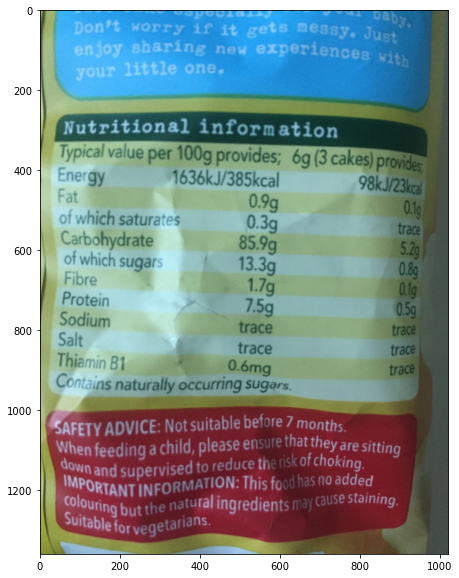

In [223]:
random_image= select_image('../../openfoodfacts-ai/nutrition-table-extraction/notebooks/data/image_files')
plt.figure(figsize=(20,10))
plt.imshow(plt.imread(random_image))

In [225]:
pipeline = Pipeline(model,tf.image.decode_jpeg((tf.io.read_file(random_image))))
pipeline.run(0.8)
column_mask_processor = ColumnMaskProcessor(pipeline.images[-1],pipeline.predicted_column_masks[-1].numpy().reshape(256,256).astype('uint8'))
column_mask_processor.process_mask()
column_mask_processor.get_peaks(20,25)
column_mask_processor.find_column_areas()

../lib\table_detection.py:262: RuntimeWarning: divide by zero encountered in true_divide
  div = np.float32(self.column_mask)/(close)
../lib\table_detection.py:262: RuntimeWarning: invalid value encountered in true_divide
  div = np.float32(self.column_mask)/(close)
../lib\table_detection.py:274: RuntimeWarning: divide by zero encountered in true_divide
  div = np.float32(self.column_mask)/(close)
../lib\table_detection.py:274: RuntimeWarning: invalid value encountered in true_divide
  div = np.float32(self.column_mask)/(close)


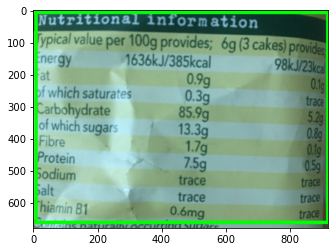

In [226]:
pipeline.tm_list[-1].draw_bounding_box()
plt.imshow(pipeline.tm_list[-1].image_with_bounding_box)
plt.plot(column_mask_processor.signal)
plt.plot(column_mask_processor.signal_peaks, column_mask_processor.signal[column_mask_processor.signal_peaks], "x")
plt.plot(np.zeros_like(column_mask_processor.signal), "--", color="gray")
plt.show()

plt.figure(figsize=(20,10))
for num, area in enumerate(column_mask_processor.column_areas):
    plt.subplot(2,len(column_mask_processor.column_areas),num+1)
    plt.title("column {}".format(num))
    plt.axis('off')
    plt.imshow(area)

NameError: name 'plt' is not defined

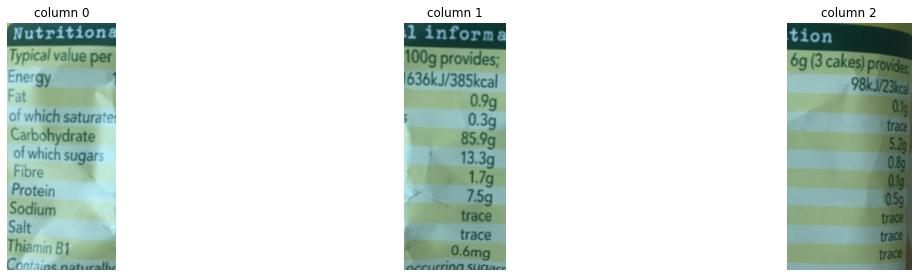

In [178]:
[area.shape for area in column_mask_processor.column_areas]

[TensorShape([1053, 622, 3]), TensorShape([1053, 419, 3])]

In [ ]:
import matplotlib.cm as cm
colors = iter(cm.Spectral(np.linspace(0,1,len(pipeline.tm_list))))
original_image = pipeline.tm_list[0].image.copy()
bbx = pipeline.tm_list[0].original_bounding_box
x,y,w,h = bbx
color = tuple(next(colors)*255)[:-1]
cv2.rectangle(original_image,(x,y),(x+w,y+h),color,10)

for i in range(1,len(pipeline.tm_list)):
    bbx = get_absolute_coordinates(bbx,pipeline.tm_list[i].original_bounding_box)
    x,y,w,h = bbx
    color = tuple(next(colors)*255)[:-1]
    cv2.rectangle(original_image,(x,y),(x+w,y+h),color,10)
    
plt.figure(figsize=(20,10))
plt.imshow(original_image)

In [ ]:
scores=[]
table_mask_dir = '../results/test_table_mask'
image_dir = '../results/test_image/'
images = [x.split('/')[-1].split('.')[0] for x in os.listdir(image_dir)]

for table_id in tqdm.tqdm(images):
    pipeline = Pipeline(model,tf.image.decode_jpeg((tf.io.read_file(os.path.join(image_dir,table_id+'.nutrition.jpg')))))
    pipeline.run(0.8)
    pipeline.get_predicted_table_mask()
    pred_mask = pipeline.predicted_table_mask
    gt_mask = cv2.imread(os.path.join('../data/test/table_mask/',table_id+'.nutrition.jpeg'))
    evaluator = Evaluator(gt_mask,pred_mask)
    scores.append(evaluator.iou())
    
print('score: {}'.format(sum(scores)/len(images)))